# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

### Импорт библиотек

In [ ]:
!pip install scikit-learn==1.1.3

In [ ]:
!pip install imblearn

     |████████████████████████████████| 226 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 1.4 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [ ]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, confusion_matrix

from sklearn.dummy import DummyClassifier

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


### Исследование данных

In [ ]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df.duplicated().sum()

0

Данные содержат 14 колонок и 10000 записей.

    -есть пропущенные значения в столбце `Tenure` (какая-то системная ошибка) - ришим, что с ними делать после исследования датасета;
    -явные дубликаты не найдены
    -ненужные столбцы (RowNumber, CustomerId, Surname) - удалим их.

<div class="paragraph"><strong>Признаки</strong></div>
<ul>
<li><em>RowNumber &mdash;</em> индекс строки в данных</li>
<li><em>CustomerId</em> &mdash; уникальный идентификатор клиента</li>
<li><em>Surname &mdash;</em> фамилия</li>
<li><em>CreditScore &mdash;</em> кредитный рейтинг</li>
<li><em>Geography &mdash;</em> страна проживания</li>
<li><em>Gender &mdash;</em> пол</li>
<li><em>Age &mdash;</em> возраст</li>
<li><em>Tenure &mdash;</em> сколько лет человек является клиентом банка</li>
<li><em>Balance &mdash;</em> баланс на счёте</li>
<li><em>NumOfProducts &mdash;</em> количество продуктов банка, используемых клиентом</li>
<li><em>HasCrCard &mdash;</em> наличие кредитной карты</li>
<li><em>IsActiveMember &mdash;</em> активность клиента</li>
<li><em>EstimatedSalary &mdash;</em> предполагаемая зарплата</li>
</ul>

<div class="paragraph"><strong>Целевой признак</strong></div>
<ul>
<li><em>Exited</em> &mdash; факт ухода клиента</li>
</ul>

### Работа с пропусками и удаление столбцов

In [ ]:
print('Пропуски в столце "Tenure" составляют', ((df.Tenure.isna().sum() / len(df.Tenure)).round(4) * 100), '% от общего количества данных')

Пропуски в столце "Tenure" составляют 9.09 % от общего количества данных


In [ ]:
df.query('Tenure.isna() == True')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,49,15766205,Yin,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,190409.34,2,1,1,138361.48,0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,85216.61,1,1,0,117369.52,1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,117593.48,2,0,0,113308.29,0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,123841.49,2,1,0,96833.00,0


Посмотрим на матрицу корреляции Пирсона, возможно пропуски можно заменить по другим столбцам.

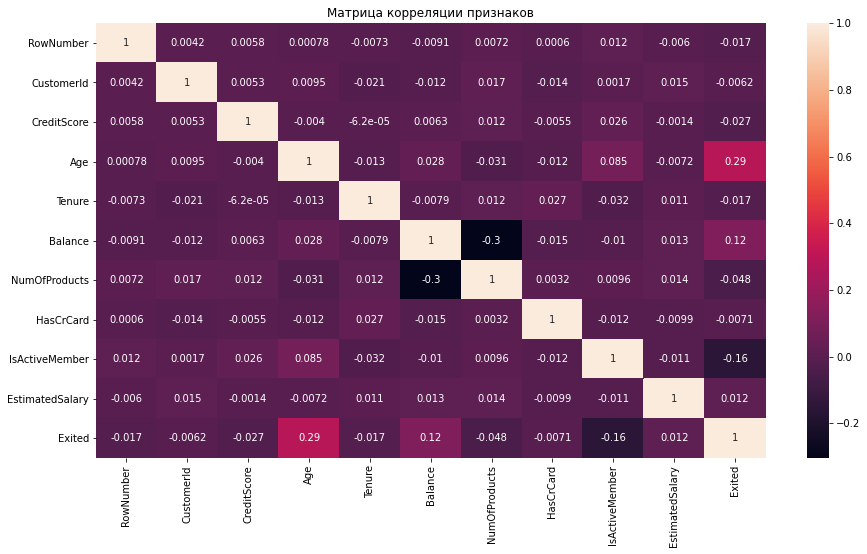

In [ ]:
plt.figure(figsize = (15,8))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True
            )
plt.title('Матрица корреляции признаков')
plt.show()

Корреляция с другими столбцами слабая. Мультиколлинеарность не обнаружена.

Посмотрим на уникальные значения в столбце `Tenure`

In [ ]:
df['Tenure'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan])

In [ ]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

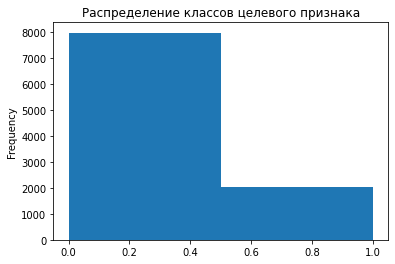

In [ ]:
df['Exited'].plot(kind ='hist', bins=2)
plt.title('Распределение классов целевого признака')
plt.show()

In [ ]:
exited_nan = df.query('Tenure.isna() == True').groupby(['Exited']).agg({'CustomerId':'count'})
exited_nan

,CustomerId
Exited,
0,726
1,183


Пропусков в данных всего 9%, распределены пропуски по отношению к целевому признаку примерно также, как и во всем датасете.
Удалим пропуски.

In [ ]:
df = df.dropna(subset=['Tenure'])
df['Tenure'].isna().sum()

0

In [ ]:
df.shape

(9091, 14)

Удалим ненужные столбцы

In [ ]:
df = df.drop(columns=['RowNumber', 'Surname', 'CustomerId'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      9091 non-null   int64  
 1   Geography        9091 non-null   object 
 2   Gender           9091 non-null   object 
 3   Age              9091 non-null   int64  
 4   Tenure           9091 non-null   float64
 5   Balance          9091 non-null   float64
 6   NumOfProducts    9091 non-null   int64  
 7   HasCrCard        9091 non-null   int64  
 8   IsActiveMember   9091 non-null   int64  
 9   EstimatedSalary  9091 non-null   float64
 10  Exited           9091 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 852.3+ KB


### Подготовка данных для машинного обучения

Используем метод OHE (drop_first=True позволит не попасть в дамми-ловушку)

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [ ]:
target = df['Exited']
features = df.drop('Exited', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size=0.4,
                                                                            random_state=12345,
                                                                            stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(features_test,
                                                                            target_test,
                                                                            test_size=0.5,
                                                                            random_state=12345,
                                                                            stratify=target_test)

print('Размер обучающей выборки:', features_train.shape)
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (5454, 10)
Размер валидационной выборки: (1818, 10)
Размер тестовой выборки: (1819, 10)


Воспользуемся OHE кодированием категориальных признаков

In [ ]:
ohe_features = features_train.select_dtypes(include='object').columns.to_list() # создадим список признаков
print(ohe_features)

['Geography', 'Gender']


In [ ]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [ ]:
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

In [ ]:
features_train = features_train.drop(ohe_features, axis=1)

In [ ]:
features_train.head(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9723,526,32,7.0,125540.05,1,0,0,86786.41,0.0,0.0,1.0
1224,500,47,8.0,128486.11,1,1,0,179227.12,0.0,1.0,0.0
8377,802,40,4.0,0.00,2,1,1,81908.09,0.0,1.0,1.0
8014,731,39,2.0,126816.18,1,1,1,74850.93,0.0,1.0,0.0
2491,612,26,4.0,0.00,2,1,1,179780.74,0.0,1.0,0.0


Трансформируем валидационную выборку

In [ ]:
features_valid[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid[ohe_features])

features_valid = features_valid.drop(ohe_features, axis=1)
features_valid.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7493,610,37,10.0,140363.95,2,1,1,129563.86,0.0,1.0,0.0
5460,661,41,5.0,122552.48,2,0,1,120646.40,1.0,0.0,1.0
9126,753,51,4.0,79811.72,2,0,1,68260.27,0.0,1.0,1.0
9801,569,30,3.0,139528.23,1,1,1,33230.37,0.0,1.0,0.0
9101,597,38,6.0,115702.67,2,1,1,25059.05,0.0,1.0,1.0


Трансформируем тестовую выборку

In [ ]:
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4126,675,32,10.0,0.00,2,1,0,191545.65,0.0,1.0,1.0
5145,784,38,1.0,138515.02,1,1,1,171768.76,1.0,0.0,1.0
9253,644,49,10.0,0.00,2,1,1,145089.64,0.0,1.0,1.0
6757,717,36,2.0,102989.83,2,0,1,49185.57,0.0,1.0,1.0
9739,677,25,3.0,0.00,2,1,0,179608.96,0.0,0.0,0.0


Масштабируем признаки

In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [ ]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(5454, 11)
(1818, 11)
(1819, 11)


In [ ]:
features_train.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9723,-1.292898,-0.660843,0.686341,0.786636,-0.910943,0,0,-0.223548,0.0,0.0,1.0
1224,-1.563714,0.778434,1.034232,0.833795,-0.910943,1,0,1.383021,0.0,1.0,0.0


In [ ]:
features_valid.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7493,-0.417955,-0.181084,1.730013,1.023931,0.789359,1,1,0.519901,0.0,1.0,0.0
5460,0.113260,0.202723,-0.009440,0.738812,0.789359,0,1,0.364920,1.0,0.0,1.0


In [ ]:
features_test.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4126,0.259084,-0.660843,1.730013,-1.222967,0.789359,1,0,1.597110,0.0,1.0,1.0
5145,1.394426,-0.085132,-1.401003,0.994334,-0.910943,1,1,1.253399,1.0,0.0,1.0


<div class="alert alert-info">В процессе предобработки данные были разделены на 3 части в соотношении 3:1:1
<p>Категориальные признаки кодированы с помощью OHE sklearn</p>
<p>Произведено масштабирование численных признаков</p>
</div>



### Обучение модели без учета дисбаланса классов

Дамми классифайр

In [ ]:
#dummy = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
#dummy_pred = dummy.predict(features_valid)
#print('Предсказанные метки: ', (np.unique(dummy_pred)))
#print('Test score: ', accuracy_score(target_valid, dummy_pred))


In [ ]:
dummy_model = DummyClassifier(strategy='constant', constant=1).fit(features_train, target_train)
print('F1 дамми-модели:', f1_score(dummy_model.predict(features_test), target_test))

F1 дамми-модели: 0.33881278538812787


Логистическая регрессия

In [ ]:
LR = LogisticRegression(solver = 'liblinear').fit(features_train, target_train)
predictions_valid_LR = LR.predict(features_valid)
print('F1:', f1_score(target_valid, predictions_valid_LR))
print('F1 дамми-модели:', f1_score(dummy_model.predict(features_test), target_test))

F1: 0.3306772908366534
F1 дамми-модели: 0.33881278538812787


Оценка точности при дисбалансе классов на фиктивной модели практически таккая же, как на модели регрессии. Надо балансировать.

Дерево решений

In [ ]:
best_model_dt = None
best_result = 0
for depth in range(1, 20):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth).fit(features_train, target_train)
    predictions_valid_dt = model_dt.predict(features_valid)
    result = f1_score(target_valid, predictions_valid_dt)
    if result > best_result:
        best_model_dt = model_dt
        best_result = result
print('F1 лучшей модели:', best_result, best_model_dt)
print('F1 дамми-модели:', f1_score(dummy_model.predict(features_test), target_test))


F1 лучшей модели: 0.5815126050420169 DecisionTreeClassifier(max_depth=7, random_state=12345)
F1 дамми-модели: 0.33881278538812787


Случайный лес

In [ ]:
best_model_RFC = None
best_result_RFC = 0
for depth in tqdm (range(1, 30)):
    for est in range(10, 200, 10):
        model_RFC = RandomForestClassifier(random_state=12345,
                                           max_depth=depth,
                                           n_estimators=est).fit(features_train, target_train)

        predictions_valid_RFC = model_RFC.predict(features_valid)
        result_RFC = f1_score(target_valid, predictions_valid_RFC)
        if result_RFC > best_result_RFC:
            best_model_RFC = model_RFC
            best_result_RFC = result_RFC

print('F1 лучшей модели:', best_result_RFC, best_model_RFC)
print('F1 дамми-модели:', f1_score(dummy_model.predict(features_test), target_test))

100%|██████████| 29/29 [06:00<00:00, 12.44s/it]

F1 лучшей модели: 0.6227347611202636 RandomForestClassifier(max_depth=19, n_estimators=130, random_state=12345)
F1 дамми-модели: 0.33881278538812787


При дисблансе классов модели случайно леса и дерева решений показывают лучшую работу, нежели линейная регрессия.

## Борьба с дисбалансом

In [ ]:
target_train.value_counts()

0    4342
1    1112
Name: Exited, dtype: int64

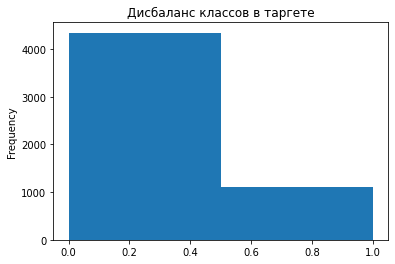

In [ ]:
target_train.plot(kind ='hist', bins=2)
plt.title('Дисбаланс классов в таргете')
plt.show()

Ушедших клиентов в 4 раза меньше оставшихся

### Увеличение наименьшего класса

Используем SMOTE для увеличения класса

In [ ]:
oversample = SMOTE(random_state=12345)
features_train_up, target_train_up = oversample.fit_resample(features_train, target_train)

In [ ]:
print(features_train_up.shape)
print(target_train_up.shape)
target_train_up.value_counts()

(8684, 11)
(8684,)


0    4342
1    4342
Name: Exited, dtype: int64

Логистическая регрессия

In [ ]:
LR_b = LogisticRegression(solver = 'liblinear').fit(features_train_up, target_train_up)
predictions_valid = LR_b.predict(features_valid)

probabilities_valid = LR_b.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('Test score: ', accuracy_score(target_valid, predictions_valid))

roc_auc: 0.7858288456272573
F1: 0.5004812319538018
Test score:  0.7145214521452146


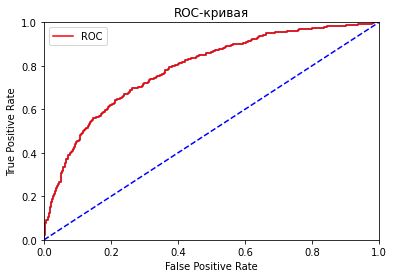

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [ ]:
best_model_dt = None
best_result = 0
for depth in range(1, 20):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth).fit(features_train_up, target_train_up)
    predictions_valid_dt = model_dt.predict(features_valid)
    result = f1_score(target_valid, predictions_valid_dt)
    if result > best_result:
        best_model_dt = model_dt
        best_result = result

probabilities_valid = best_model_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1 лучшей модели:', best_result, best_model_dt)

roc_auc: 0.8167032078638395
F1 лучшей модели: 0.5893958076448829 DecisionTreeClassifier(max_depth=7, random_state=12345)


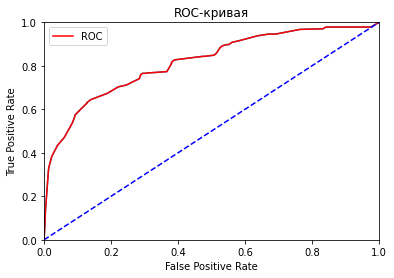

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Случайный лес

In [ ]:
best_model_rf = None
best_result = 0
for est in tqdm(range(10, 100, 10)):
    for depth in range(1, 30):
        model_rf = RandomForestClassifier(n_estimators=est,
                                          max_depth=depth,
                                          random_state=12345).fit(features_train_up,
                                                                  target_train_up)
        pred_rf = model_rf.predict(features_valid)
        result = f1_score(target_valid, pred_rf)
        if result > best_result:
            best_model_rf = model_rf
            best_result = result

probabilities_valid = best_model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1 лучшей модели:', best_result, best_model_rf)

100%|██████████| 9/9 [02:26<00:00, 16.29s/it]

roc_auc: 0.8689397340347255
F1 лучшей модели: 0.6443298969072164 RandomForestClassifier(max_depth=9, n_estimators=20, random_state=12345)


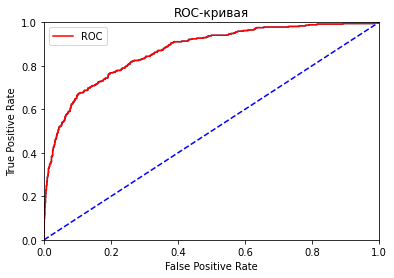

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

### Уменьшение класса

Создадим функцию уменьшения класса

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)

    return features_downsampled, target_downsampled

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)
print(features_downsampled.shape)
print(target_downsampled.shape)
target_downsampled.value_counts()

(2415, 11)
(2415,)


0    1303
1    1112
Name: Exited, dtype: int64

In [ ]:
#Логистическая регрессия

LR_d = LogisticRegression(solver = 'liblinear').fit(features_downsampled, target_downsampled)
predictions_valid = LR_d.predict(features_valid)

probabilities_valid = LR_d.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1:',f1_score(target_valid, predictions_valid))
print('Test score: ', accuracy_score(target_valid, predictions_valid))

roc_auc: 0.7910110517717669
F1: 0.5138746145940392
Test score:  0.7398239823982399


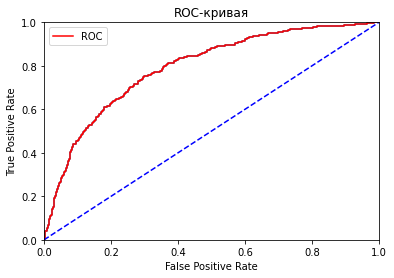

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [ ]:
# Дерево решений

best_model_dt_d = None
best_result = 0
for depth in range(1, 20):
    model_dt_d = DecisionTreeClassifier(random_state=12345, max_depth=depth).fit(features_downsampled, target_downsampled)
    predictions_valid_dt_d = model_dt_d.predict(features_valid)
    result = f1_score(target_valid, predictions_valid_dt_d)
    if result > best_result:
        best_model_dt_d = model_dt_d
        best_result = result
probabilities_valid = best_model_dt_d.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1 лучшей модели:', best_result, best_model_dt_d)

roc_auc: 0.8403919625510163
F1 лучшей модели: 0.5842450765864333 DecisionTreeClassifier(max_depth=6, random_state=12345)


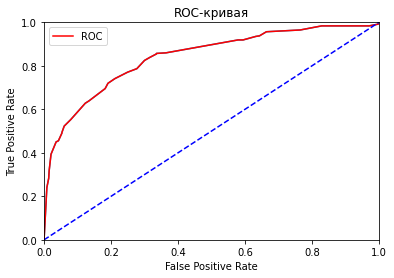

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [ ]:
# Случайный лес

best_model_rf_d = None
best_result = 0
for est in tqdm(range(10, 100, 10)):
    for depth in range(1, 30):
        model_rf_d = RandomForestClassifier(n_estimators=est,
                                          max_depth=depth,
                                          random_state=12345).fit(features_downsampled,
                                                                  target_downsampled)
        pred_rf_d = model_rf_d.predict(features_valid)
        result = f1_score(target_valid, pred_rf_d)
        if result > best_result:
            best_model_rf_d = model_rf_d
            best_result = result

probabilities_valid = best_model_rf_d.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1 лучшей модели:', best_result, best_model_rf_d)

100%|██████████| 9/9 [00:53<00:00,  5.91s/it]

roc_auc: 0.8779052114515207
F1 лучшей модели: 0.6349206349206349 RandomForestClassifier(max_depth=12, n_estimators=80, random_state=12345)


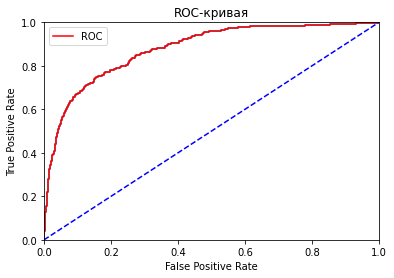

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

### Взвешивание классов

In [ ]:
# Логистическая регрессия

LR_balanced = LogisticRegression(solver = 'liblinear', class_weight='balanced').fit(features_train, target_train)
predictions_valid_LR_balanced = LR_balanced.predict(features_valid)

probabilities_valid = LR_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1:', f1_score(target_valid, predictions_valid_LR_balanced))
print('Test score: ', accuracy_score(target_valid, predictions_valid_LR_balanced))

roc_auc: 0.790763304317698
F1: 0.5065420560747663
Test score:  0.7095709570957096


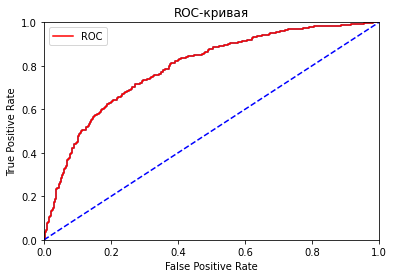

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [ ]:
# Дерево решений

best_model_DTC_balanced = None
best_result = 0
for depth in range(1, 20):
    DTC_balanced = DecisionTreeClassifier(random_state=12345,
                                          max_depth=depth,
                                          class_weight='balanced').fit(features_train,
                                                                       target_train)
    DTC_balanced_pred = DTC_balanced.predict(features_valid)
    result = f1_score(target_valid, DTC_balanced_pred)
    if result > best_result:
        best_model_DTC_balanced = DTC_balanced
        best_result = result

probabilities_valid = DTC_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1 лучшей модели:', best_result, best_model_DTC_balanced)

roc_auc: 0.7056946521942414
F1 лучшей модели: 0.583084577114428 DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)


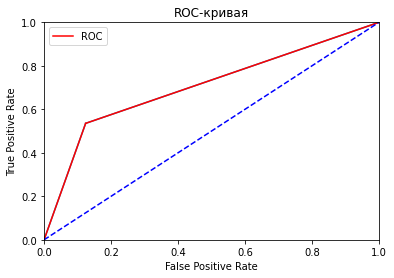

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

In [ ]:
# Случайный лес

best_model_rf_balanced = None
best_result = 0
for est in tqdm(range(10, 100, 10)):
    for depth in range(1, 30):
        model_rf_balanced = RandomForestClassifier(n_estimators=est,
                                          max_depth=depth,
                                          random_state=12345,
                                          class_weight='balanced').fit(features_train,
                                                                  target_train)
        pred_rf_balanced = model_rf_balanced.predict(features_valid)
        result = f1_score(target_valid, pred_rf_balanced)
        if result > best_result:
            best_model_rf_balanced = model_rf_balanced
            best_result = result

probabilities_valid = model_rf_balanced.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]


print('roc_auc:', roc_auc_score(target_valid, probabilities_one_valid))
print('F1 лучшей модели:', best_result, best_model_rf_balanced)

100%|██████████| 9/9 [01:31<00:00, 10.16s/it]

roc_auc: 0.8676385942101605
F1 лучшей модели: 0.6428571428571429 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=40,
                       random_state=12345)


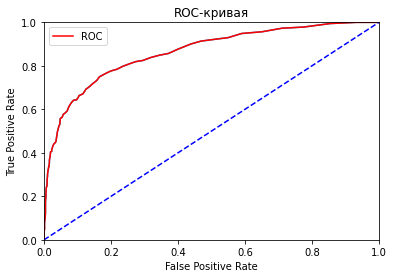

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

<p>Борьба с дисбалансом велась долго, но уверенно, в результате мы получили следующие данные:</p>
<p><strong>Увеличение наименьшего класса:</strong></p>
<p><em>Логистическая регрессия</em></p>
<pre>roc_auc: 0.790767029843323
F1: 0.5050878815911193</pre>
<p><em>Дерево решений</em></p>
<pre>roc_auc: 0.8347040163029001
F1 лучшей модели: 0.5825049701789264 DecisionTreeClassifier(max_depth=6, random_state=12345)</pre>
<p><em>Случайный лес</em></p>
<pre>roc_auc: 0.8689397340347255
F1 лучшей модели: 0.6443298969072164 RandomForestClassifier(max_depth=12, n_estimators=20, random_state=12345)</pre>
<p><em><strong>Уменьшение класса:</strong></em></p>
<p><em>Логистическая регрессия</em></p>
<pre>roc_auc: 0.7910110517717669
F1: 0.5138746145940392</pre>
<p><em>Дерево решений</em></p>
<pre>roc_auc: 0.8403919625510163
F1 лучшей модели: 0.5842450765864333 DecisionTreeClassifier(max_depth=6, random_state=12345)</pre>
<p><em>Случайный лес</em></p>
<pre>roc_auc: 0.8779052114515207
F1 лучшей модели: 0.6349206349206349 RandomForestClassifier(max_depth=12, n_estimators=80, random_state=12345)</pre>
<p><em><strong>Взвешивание классов:</strong></em></p>
<p><em>Логистическая регрессия</em></p>
<pre>roc_auc: 0.790763304317698
F1: 0.5065420560747663</pre>
<p><em>Дерево решений</em></p>
<pre>roc_auc: 0.6922613381715493
F1 лучшей модели: 0.583084577114428 DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=12345)</pre>
<p><em>Случайный лес</em></p>
<pre>roc_auc: 0.8638311070213118
F1 лучшей модели: 0.6463878326996199 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=50,
                       random_state=12345)</pre>
<pre><br /><br />Лучший результат на валидационной выборке получились у Случайного леса с параметрами roc_auc: 0.8638311070213118
F1 лучшей модели: 0.6463878326996199 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=50,
                       random_state=12345) <br /><br />Испробуем его на тестовой выборке</pre>
<pre><br /><br /><br /></pre>

## Тестирование модели

Объеденим обучающую и валидационную выборки для тестирования модели

In [ ]:
features_super = pd.concat([features_valid, features_train])
target_super = pd.concat([target_valid, target_train])
features_super, target_super = shuffle(features_super, target_super, random_state=12345)

Обучим и затестим модель

In [ ]:
best_model_rf_balanced.fit(features_super, target_super)
predictions_test = best_model_rf_balanced.predict(features_test)

probabilities_valid = best_model_rf_balanced.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

print(best_model_rf_balanced)
print('roc_auc:', roc_auc_score(target_test, probabilities_one_valid))
print('F1:', f1_score(target_test, predictions_test))
print('F1 дамми-модели:', f1_score(dummy_model.predict(features_test), target_test))
print('Recall', recall_score(target_test, predictions_test))

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=40,
                       random_state=12345)
roc_auc: 0.8546410328960105
F1: 0.6051948051948053
F1 дамми-модели: 0.33881278538812787
Recall 0.628032345013477


По метрике recall понятно, что модель верно детектирует долю в 62,8% от всех клиентов на отток. Но и это уже не плохо.

In [ ]:
confusion_matrix(target_test, predictions_test)

array([[1282,  166],
       [ 138,  233]])

Посмотрим на график ROC-кривой. Созданная модель довольно сильно отличается от случайной.

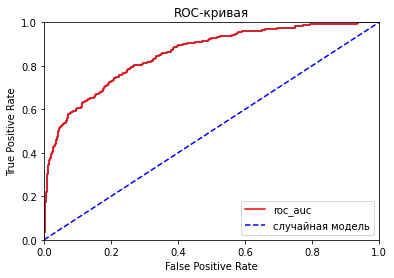

In [ ]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.plot(fpr, tpr)
plt.plot(fpr, tpr, color='red', label='roc_auc')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='случайная модель')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.show()

Взглянем на важность признаков нашей модели

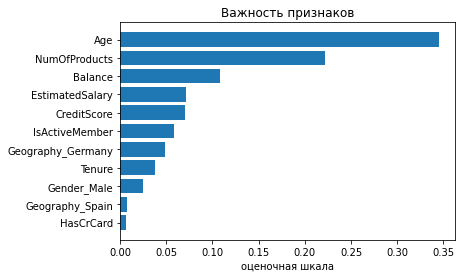

In [ ]:
features=features_test.columns
importances = best_model_rf_balanced.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('оценочная шкала')
plt.show()

## Вывод

<div class="paragraph">Из &laquo;Бета-Банка&raquo; стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.</div>
<div class="paragraph">В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. Необходимо простроить модель машинного обучения с предельно большим значением <em>F1</em>-меры и спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.</div>
<div class="paragraph">&nbsp;</div>
<div class="paragraph">
<p>Данные содержат 14 колонок и 10000 записей.</p>
<p>В ходе исследования данных были удалены пропущенные значения в столбце `Tenure` и удалены ненужные столбцы (RowNumber, CustomerId, Surname), мультиколлинеарность не обнаружена.</p>
<p>Присутствует дисбаланс целевого признака.</p>
<p>Было проведено обучение моделей Логистической регрессии, Случайного леса и Дерева решений.</p>
<p>Вначале без учета дисбаланса классов:</p>
<p>Линейная регрессия дала дала показания близкие к константной модели, Случайный лес и Дерево решений справились лучше.</p>
<p>В ходе борьбы с дисбалансом классов, были обучены модели с использованием увеличения наименьшего класса, уменьшения наибольшего класса и взвешивания классов.&nbsp;</p>
<p>Лучший результат на валидационной выборке получился у Случайного леса с параметрами roc_auc: 0.8638311070213118<br />F1 лучшей модели: 0.6463878326996199 RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=50,<br />random_state=12345)</p>
<p>Его и использовали для тестирование модели, объеденив при этом обучающую и валидационную выборки для лучшего обучения тестовой модели.</p>
<p>Метрики показали следующие результаты:</p>
<pre>roc_auc: 0.8537084332325654
F1: 0.6064516129032258<br />F1 дамми-модели: 0.33881278538812787
Recall 0.628032345013477</pre>
<pre>По сравнению с дамми-моделью видно, что наша модель показывает лучшие результаты.<br />По метрике recall понятно, что модель верно детектирует долю в 62,8% от всех клиентов на отток. Но и это уже не плохо.<br /><br />Метрика F1 больше 0.59. Ура!</pre>
<p>&nbsp;</p>
</div>